### Bone Fracture Classification Using Convolutional Neural Networks 

In [74]:
import os
import torch
import warnings
import shutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from tqdm.auto import tqdm
from PIL import Image, ImageFile
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import torchvision
from torchvision import models, transforms
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, default_collate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

In [75]:
# Configuration
ImageFile.LOAD_TRUNCATED_IMAGES = True
warnings.filterwarnings("ignore")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
IMAGE_SIZE = 224 
BATCH_SIZE = 16
EPOCHS = 10

In [76]:
# Color settings for plots
color_list = ['#faa5c7', '#eb679c', '#cc3d76', '#b3245d', '#d40457', '#8f1042', '#6e042e']
cmap = LinearSegmentedColormap.from_list('custom_palette', color_list, N=256)
sns.set_palette(sns.color_palette(color_list))


In [77]:
# Color settings for plots
color_list = ['#faa5c7', '#eb679c', '#cc3d76', '#b3245d', '#d40457', '#8f1042', '#6e042e']
cmap = LinearSegmentedColormap.from_list('custom_palette', color_list, N=256)
sns.set_palette(sns.color_palette(color_list))


In [78]:
# Functions to clean dataset
def removeCorruptFiles(directory_path):
    for item in os.listdir(directory_path):
        item_path = os.path.join(directory_path, item)
        if os.path.isdir(item_path):
            removeCorruptFiles(item_path)
        else:
            try:
                Image.open(item_path).verify()
            except (IOError, SyntaxError):
                os.remove(item_path)
                print(f'Removed corrupted image: {item}')

In [79]:
def removeEmptySubdirectories(directory):
    for entry in os.listdir(directory):
        full_path = os.path.join(directory, entry)
        if os.path.isdir(full_path):
            removeEmptySubdirectories(full_path)
            if not os.listdir(full_path):
                os.rmdir(full_path)
                print(f"Removed empty directory: {full_path}")


In [80]:
def copyDatasetIntoWorkingDir(source_directory, destination_directory):
    if os.path.exists(destination_directory):
        shutil.rmtree(destination_directory)
    shutil.copytree(source_directory, destination_directory)

In [81]:
# Copy and clean dataset
copyDatasetIntoWorkingDir(input_directory, dataset_directory)
removeCorruptFiles(output_train_directory)
removeCorruptFiles(output_dev_directory)
removeCorruptFiles(output_test_directory)


In [82]:
# Data transformations
transform = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
        transforms.Resize((224, 224)),  # Resize to 224x224 pixels
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'dev': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
        transforms.Resize((224, 224)),  # Resize to 224x224 pixels
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
        transforms.Resize((224, 224)),  # Resize to 224x224 pixels
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

In [83]:
# Datasets and loaders
datasets = {
    'train': torchvision.datasets.ImageFolder(root=output_train_directory, transform=transform['train']),
    'dev': torchvision.datasets.ImageFolder(root=output_dev_directory, transform=transform['dev']),
    'test': torchvision.datasets.ImageFolder(root=output_test_directory, transform=transform['test'])
}

In [84]:
def my_collate(batch):
    "Puts each data field into a tensor with outer dimension batch size"
    batch = list(filter(lambda x:x is not None, batch))
    return default_collate(batch)

In [85]:
dataloaders = {
    'train': DataLoader(datasets['train'], batch_size=BATCH_SIZE, shuffle=True, collate_fn=my_collate),
    'dev': DataLoader(datasets['dev'], batch_size=BATCH_SIZE, collate_fn=my_collate),
    'test': DataLoader(datasets['test'], batch_size=BATCH_SIZE, collate_fn=my_collate)
}


### Our CNN model

In [86]:
class AdvancedCNN(nn.Module):
    def __init__(self):
        super(AdvancedCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: [batch_size, 32, 112, 112]

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: [batch_size, 64, 56, 56]

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: [batch_size, 128, 28, 28]

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: [batch_size, 256, 14, 14]
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 14 * 14, 1024),  # Adjust input dimension to 256*14*14
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 512),  # Input: 1024, Output: 512
            nn.ReLU(inplace=True),
            nn.Linear(512, 128),  # Input: 512, Output: 128
            nn.ReLU(inplace=True),
            nn.Linear(128, 2)  # Input: 128, Output: 2 (number of classes)
        )
        self.printed = False  # Flag to ensure dimensions are printed only once per epoch

    def forward(self, x):
        if not self.printed:
            print(f'Initial input dimensions: {x.shape}')  # Initial input dimensions
        x = self.features[0](x)
        if not self.printed:
            print(f'After first conv layer: {x.shape}')  # After first conv layer
        x = self.features[1](x)
        x = self.features[2](x)
        x = self.features[3](x)
        if not self.printed:
            print(f'After first max pool layer: {x.shape}')  # After first max pool layer
        x = self.features[4](x)
        x = self.features[5](x)
        x = self.features[6](x)
        x = self.features[7](x)
        if not self.printed:
            print(f'After second conv layer: {x.shape}')  # After second conv layer
        x = self.features[8](x)
        x = self.features[9](x)
        x = self.features[10](x)
        x = self.features[11](x)
        if not self.printed:
            print(f'After third conv layer: {x.shape}')  # After third conv layer
        x = self.features[12](x)
        x = self.features[13](x)
        x = self.features[14](x)
        x = self.features[15](x)
        if not self.printed:
            print(f'After fourth conv layer: {x.shape}')  # After fourth conv layer
        x = x.view(x.size(0), -1)  # Flatten the tensor
        if not self.printed:
            print(f'Flattened vector: {x.shape}')  # Print dimensions after flattening
        x = self.classifier(x)
        self.printed = True  # Set the flag to True after printing dimensions
        return x


### ResNet50 model

In [87]:
# Define the ResNet50 model
class ResNet50Binary(nn.Module):
    def __init__(self):
        super(ResNet50Binary, self).__init__()
        self.model = models.resnet50(pretrained=True)
        # Modify the last fully connected layer to output 2 classes
        self.model.fc = nn.Linear(self.model.fc.in_features, 2)

    def forward(self, x):
        return self.model(x)

### VGG16 model

In [88]:
# Define the VGG16 model
class VGG16Binary(nn.Module):
    def __init__(self):
        super(VGG16Binary, self).__init__()
        self.model = models.vgg16(pretrained=True)
        # Modify the last classifier layer to output 2 classes
        self.model.classifier = nn.Sequential(
            nn.Linear(self.model.classifier[0].in_features, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 2)
        )

    def forward(self, x):
        return self.model(x)

### Training the Model

In [89]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0
        all_labels = []
        all_preds = []

        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders['train'].dataset)
        train_losses.append(epoch_loss)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        scheduler.step()
        model.printed = False 

    return model, train_losses


In [90]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_labels = []
    all_preds = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    total_loss = running_loss / len(dataloader.dataset)
    total_acc = running_corrects.double() / len(dataloader.dataset)

    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')

    print(f'Loss: {total_loss:.4f} Acc: {total_acc:.4f}')
    print(f'Precision: {precision:.4f} Recall: {recall:.4f} F1 Score: {f1:.4f}')

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataloader.dataset.classes)
    disp.plot(cmap='Blues')
    plt.show()

    return total_loss, total_acc, precision, recall, f1


In [91]:
def plot_metrics(metrics, model_names):
    metrics = np.array(metrics)
    num_metrics = metrics.shape[1]
    fig, axes = plt.subplots(1, num_metrics, figsize=(20, 5))

    for i, ax in enumerate(axes):
        ax.bar(model_names, metrics[:, i])
        ax.set_title(metrics_names[i])
        ax.set_xlabel('Models')
        ax.set_ylabel(metrics_names[i])

    plt.show()

In [92]:
def plot_loss_curves(train_losses, model_names):
    plt.figure(figsize=(10, 5))
    for i, losses in enumerate(train_losses):
        plt.plot(losses, label=model_names[i])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curves')
    plt.legend()
    plt.show()


In [93]:
# Initialize models, criterion, optimizer, and scheduler
cnn_model = AdvancedCNN().to(device)
resnet_model = ResNet50Binary().to(device)
vgg16_model = VGG16Binary().to(device)

criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)
vgg16_optimizer = optim.Adam(vgg16_model.parameters(), lr=0.0001)


In [94]:
# Learning rate schedulers
cnn_scheduler = StepLR(cnn_optimizer, step_size=7, gamma=0.1)
resnet_scheduler = StepLR(resnet_optimizer, step_size=7, gamma=0.1)
vgg16_scheduler = StepLR(vgg16_optimizer, step_size=7, gamma=0.1)


Epoch 0/9
----------
Initial input dimensions: torch.Size([16, 3, 224, 224])
After first conv layer: torch.Size([16, 32, 224, 224])
After first max pool layer: torch.Size([16, 32, 112, 112])
After second conv layer: torch.Size([16, 64, 56, 56])
After third conv layer: torch.Size([16, 128, 28, 28])
After fourth conv layer: torch.Size([16, 256, 14, 14])
Flattened vector: torch.Size([16, 50176])
Train Loss: 0.6006 Acc: 0.6876
Epoch 1/9
----------
Initial input dimensions: torch.Size([16, 3, 224, 224])
After first conv layer: torch.Size([16, 32, 224, 224])
After first max pool layer: torch.Size([16, 32, 112, 112])
After second conv layer: torch.Size([16, 64, 56, 56])
After third conv layer: torch.Size([16, 128, 28, 28])
After fourth conv layer: torch.Size([16, 256, 14, 14])
Flattened vector: torch.Size([16, 50176])
Train Loss: 0.4457 Acc: 0.7965
Epoch 2/9
----------
Initial input dimensions: torch.Size([16, 3, 224, 224])
After first conv layer: torch.Size([16, 32, 224, 224])
After first ma

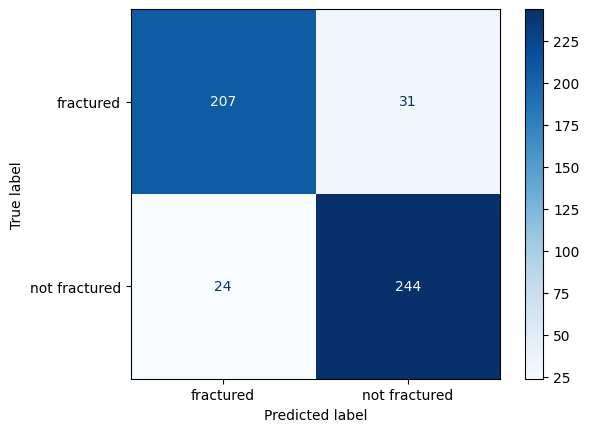

In [95]:
# Train and evaluate CNN model
cnn_model, cnn_train_losses = train_model(cnn_model, criterion, cnn_optimizer, cnn_scheduler, num_epochs=EPOCHS)
cnn_metrics = evaluate_model(cnn_model, dataloaders['test'], criterion)


Epoch 0/9
----------
Train Loss: 0.5864 Acc: 0.6977
Epoch 1/9
----------
Train Loss: 0.4508 Acc: 0.7890
Epoch 2/9
----------
Train Loss: 0.3128 Acc: 0.8741
Epoch 3/9
----------
Train Loss: 0.2380 Acc: 0.9053
Epoch 4/9
----------
Train Loss: 0.1855 Acc: 0.9332
Epoch 5/9
----------
Train Loss: 0.1658 Acc: 0.9401
Epoch 6/9
----------
Train Loss: 0.1266 Acc: 0.9566
Epoch 7/9
----------
Train Loss: 0.0708 Acc: 0.9790
Epoch 8/9
----------
Train Loss: 0.0489 Acc: 0.9857
Epoch 9/9
----------
Train Loss: 0.0584 Acc: 0.9827
Loss: 0.1556 Acc: 0.9368
Precision: 1.0000 Recall: 0.8806 F1 Score: 0.9365


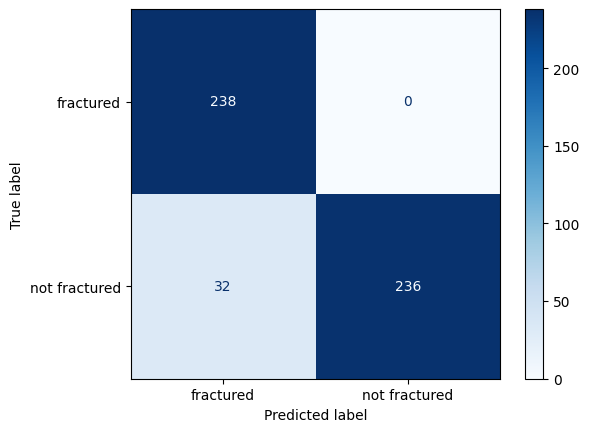

In [96]:
# Train and evaluate ResNet model
resnet_model, resnet_train_losses = train_model(resnet_model, criterion, resnet_optimizer, resnet_scheduler, num_epochs=EPOCHS)
resnet_metrics = evaluate_model(resnet_model, dataloaders['test'], criterion)

Epoch 0/9
----------
Train Loss: 0.3092 Acc: 0.8545
Epoch 1/9
----------
Train Loss: 0.0813 Acc: 0.9723
Epoch 2/9
----------
Train Loss: 0.0527 Acc: 0.9853
Epoch 3/9
----------
Train Loss: 0.0432 Acc: 0.9866
Epoch 4/9
----------
Train Loss: 0.0364 Acc: 0.9877
Epoch 5/9
----------
Train Loss: 0.0420 Acc: 0.9875
Epoch 6/9
----------
Train Loss: 0.0361 Acc: 0.9885
Epoch 7/9
----------
Train Loss: 0.0093 Acc: 0.9969
Epoch 8/9
----------
Train Loss: 0.0057 Acc: 0.9978
Epoch 9/9
----------
Train Loss: 0.0060 Acc: 0.9977
Loss: 0.0638 Acc: 0.9763
Precision: 0.9848 Recall: 0.9701 F1 Score: 0.9774


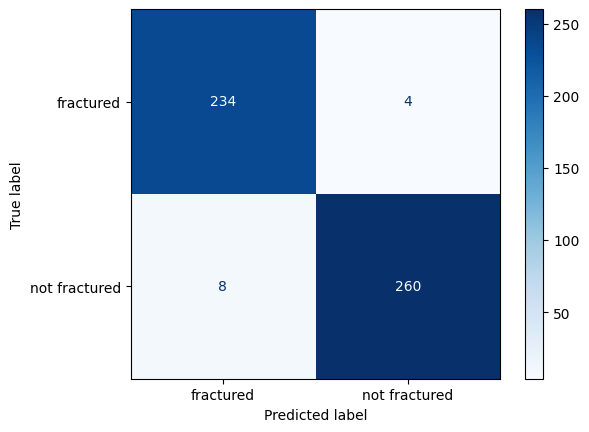

In [97]:
# Train and evaluate VGG16 model
vgg16_model, vgg16_train_losses = train_model(vgg16_model, criterion, vgg16_optimizer, vgg16_scheduler, num_epochs=EPOCHS)
vgg16_metrics = evaluate_model(vgg16_model, dataloaders['test'], criterion)


In [98]:
# Convert tensors to CPU before plotting
cnn_metrics = [metric.cpu().numpy() if isinstance(metric, torch.Tensor) else metric for metric in cnn_metrics]
resnet_metrics = [metric.cpu().numpy() if isinstance(metric, torch.Tensor) else metric for metric in resnet_metrics]
vgg16_metrics = [metric.cpu().numpy() if isinstance(metric, torch.Tensor) else metric for metric in vgg16_metrics]

In [99]:
# Plot comparison
metrics = [cnn_metrics, resnet_metrics, vgg16_metrics]
model_names = ['AdvancedCNN', 'ResNet50', 'VGG16']
metrics_names = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score']

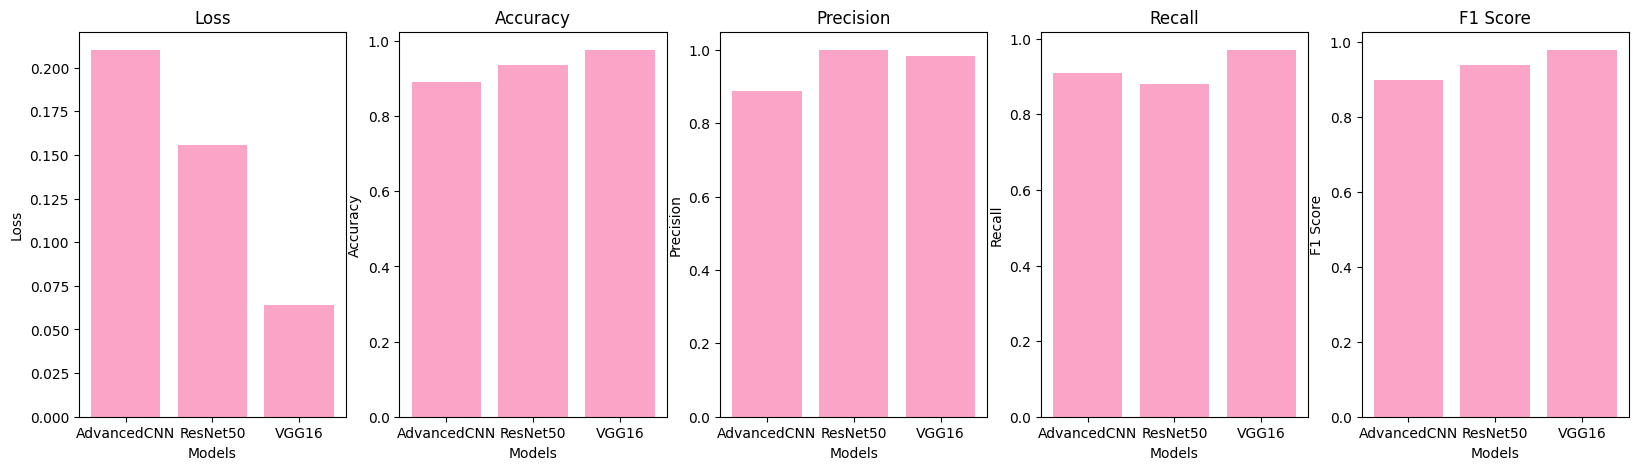

In [100]:
plot_metrics(metrics, model_names)

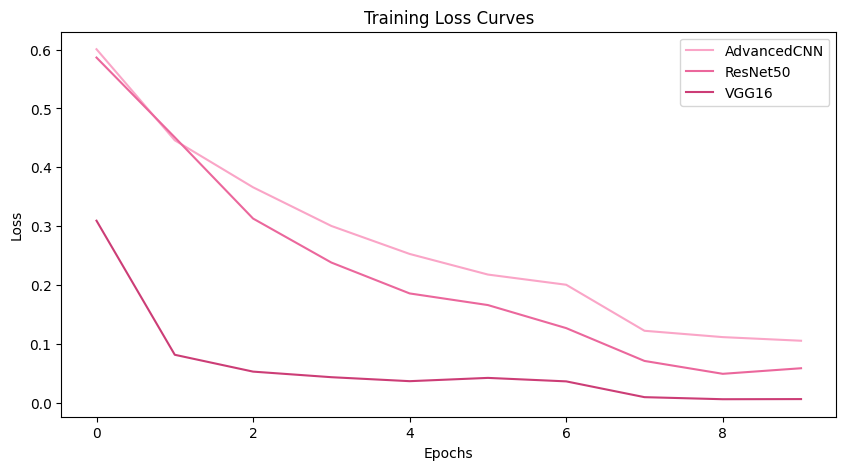

In [101]:
# Plot loss curves
train_losses = [cnn_train_losses, resnet_train_losses, vgg16_train_losses]
plot_loss_curves(train_losses, model_names)